## Classifier Performance: Constructing a QSO catalogue
#### Plot to show performance when constructing a catalogue
In this notebook, we load the results from all of our classifiers on a DESI-like subset of the BOSS DR12Q Superset, and compare the results in the context of constructing a QSO catalogue. We define different strategies for combining the classifiers' classifications, and assess which of these is preferable.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
  
import astropy
import copy
import numpy as np
from matplotlib import pyplot as plt

from quasarnet.io import read_truth
from qn_analysis import plot, strategy, utils, variables

In [2]:
figsize = (12,8)
fontsize = 18

plt.rc('font', size=fontsize)

### Load the results from the different classifiers

In [3]:
common_specids = False

## RR parameters
include_fits_rr = True

## QN parameters
n_detect = 1
c_th = 0.8
include_c_qn = True

## SQ parameters
p_min = 0.32
include_p_sq = True

In [4]:
f_truth = variables.OUTDIR+'/data/truth/truth_dr12q.fits'
truth = read_truth([f_truth])

In [5]:
data = {}

## Load the RRold data.
f_rr = variables.OUTDIR+'/results/rr_results/old/rr_sdr12q.fits'
data['RRold'] = utils.load_rr_data(f_rr)

## Load the RRarch data.
f_rr = variables.OUTDIR+'/results/rr_results/rr_sdr12q_archetypes_coadd.fits'
data['RRarch'] = utils.load_rr_data(f_rr,include_fits=include_fits_rr)

## Load the RRarch data.
f_rr = variables.OUTDIR+'/results/rr_results/rr_sdr12q_archetypes_andmask_coadd.fits'
data['RRarch andmask'] = utils.load_rr_data(f_rr,include_fits=include_fits_rr)

## Load the RR data.
f_rr = variables.OUTDIR+'/results/rr_results/rr_sdr12q_coadd.fits'
data['RR coadd'] = utils.load_rr_data(f_rr,include_fits=include_fits_rr)

## Load the RRngp data.
f_rr = variables.OUTDIR+'/results/rr_results/rr_test_coadd_ngp.fits'
data['RRngp coadd'] = utils.load_rr_data(f_rr,include_fits=include_fits_rr)

## Load the RR andmask data.
f_rr = variables.OUTDIR+'/results/rr_results/rr_sdr12q_andmask_coadd.fits'
data['RR andmask coadd'] = utils.load_rr_data(f_rr,include_fits=include_fits_rr)

## Load the RRngp andmask randexp data.
f_rr = variables.OUTDIR+'/results/rr_results/rr_sdr12q_andmask_randexp.fits'
data['RRngp andmask randexp'] = utils.load_rr_data(f_rr,include_fits=include_fits_rr)

## Load the RRngp andmask bestexp data.
f_rr = variables.OUTDIR+'/results/rr_results/rr_sdr12q_andmask_bestexp.fits'
data['RRngp andmask bestexp'] = utils.load_rr_data(f_rr,include_fits=include_fits_rr)

## Load BOSS pipeline data.
f_pipe = variables.OUTDIR+'/results/dr12pipe_results/dr12pipe_sdr12q.fits'
data['PIPE'] = utils.load_rr_data(f_pipe,include_fits=include_fits_rr)

## Load the QN data.
f_qn = variables.OUTDIR+'/outputs/qn_outputs/main_setup/coadd/prop_0.1/model_indtrain_0_0/qnAll-train_0.1_coadd_0_0-test_coadd.fits'
data['QN coadd'] = utils.load_qn_data(f_qn,n_detect=n_detect,c_th=c_th,include_c=include_c_qn)

## Load the QN randexp data.
singexp_mode = 'randexp'
f_qn = variables.OUTDIR+'/outputs/qn_outputs/main_setup/{m}/prop_0.1/model_indtrain_0_0/qnAll-train_0.1_{m}_0_0-test_{m}.fits'.format(m=singexp_mode)
data['QN randexp'] = utils.load_qn_data(f_qn,n_detect=n_detect,c_th=c_th,include_c=include_c_qn)

## Load the QN bestexp data.
singexp_mode = 'bestexp'
f_qn = variables.OUTDIR+'/outputs/qn_outputs/main_setup/{m}/prop_0.1/model_indtrain_0_0/qnAll-train_0.1_{m}_0_0-test_{m}.fits'.format(m=singexp_mode)
data['QN bestexp'] = utils.load_qn_data(f_qn,n_detect=n_detect,c_th=c_th,include_c=include_c_qn)

## Load the SQ data.
f_sq = variables.OUTDIR+'/results/sq_results/sq_sdr12q.fits'
data['SQ'] = utils.load_sq_data(f_sq,p_min=p_min,include_p=include_p_sq)

In [8]:
for k in data.keys():
    print(k,len(data[k]))

RRold 546856
RRarch 625167
RRarch andmask 625033
RR coadd 625167
RRngp coadd 282016
RR andmask coadd 625033
RRngp andmask randexp 621482
RRngp andmask bestexp 621483
PIPE 627751
QN coadd 526466
QN randexp 526624
QN bestexp 526533
SQ 545494


### Find the set of common spectra, and reduce all data to that set
This finds which spectra* are common to all datasets, and removes any that are not common. It then matches the data from each classifier to each spectrum, and produces a single data table.

\* using spec_id = plate$\times$1000000000 + mjd$\times$10000 + fiber for BOSS, or spec_id = targetid for DESI (to be updated)

In [9]:
data_table = utils.reduce_data_to_table(data,truth,
                                  include_c_qn=include_c_qn,
                                  include_p_sq=include_p_sq,
                                  include_fits_rr=include_fits_rr,
                                  common_specids=common_specids,
                                  )

WARN: could not find redrock fit data in RRold


SPEC_ID,OBJ_ID,ZCONF_PERSON,Z_VI,CLASS_VI,ISQSO_VI,Z_RRold,CLASS_RRold,ISQSO_RRold,ZWARN_RRold,Z_RRarch,CLASS_RRarch,ISQSO_RRarch,FIT_SPECTYPE_RRarch [9],FIT_Z_RRarch [9],FIT_CHI2_RRarch [9],FIT_ZWARN_RRarch [9],FIT_RCHI2_RRarch [9],ZWARN_RRarch,Z_RRarch andmask,CLASS_RRarch andmask,ISQSO_RRarch andmask,FIT_SPECTYPE_RRarch andmask [9],FIT_Z_RRarch andmask [9],FIT_CHI2_RRarch andmask [9],FIT_ZWARN_RRarch andmask [9],FIT_RCHI2_RRarch andmask [9],ZWARN_RRarch andmask,Z_RR coadd,CLASS_RR coadd,ISQSO_RR coadd,FIT_SPECTYPE_RR coadd [9],FIT_Z_RR coadd [9],FIT_CHI2_RR coadd [9],FIT_ZWARN_RR coadd [9],FIT_RCHI2_RR coadd [9],ZWARN_RR coadd,Z_RRngp coadd,CLASS_RRngp coadd,ISQSO_RRngp coadd,FIT_SPECTYPE_RRngp coadd [9],FIT_Z_RRngp coadd [9],FIT_CHI2_RRngp coadd [9],FIT_ZWARN_RRngp coadd [9],FIT_RCHI2_RRngp coadd [9],ZWARN_RRngp coadd,Z_RR andmask coadd,CLASS_RR andmask coadd,ISQSO_RR andmask coadd,FIT_SPECTYPE_RR andmask coadd [9],FIT_Z_RR andmask coadd [9],FIT_CHI2_RR andmask coadd [9],FIT_ZWARN_RR andmask coadd [9],FIT_RCHI2_RR andmask coadd [9],ZWARN_RR andmask coadd,Z_RRngp andmask randexp,CLASS_RRngp andmask randexp,ISQSO_RRngp andmask randexp,FIT_SPECTYPE_RRngp andmask randexp [9],FIT_Z_RRngp andmask randexp [9],FIT_CHI2_RRngp andmask randexp [9],FIT_ZWARN_RRngp andmask randexp [9],FIT_RCHI2_RRngp andmask randexp [9],ZWARN_RRngp andmask randexp,Z_RRngp andmask bestexp,CLASS_RRngp andmask bestexp,ISQSO_RRngp andmask bestexp,FIT_SPECTYPE_RRngp andmask bestexp [9],FIT_Z_RRngp andmask bestexp [9],FIT_CHI2_RRngp andmask bestexp [9],FIT_ZWARN_RRngp andmask bestexp [9],FIT_RCHI2_RRngp andmask bestexp [9],ZWARN_RRngp andmask bestexp,Z_PIPE,CLASS_PIPE,ISQSO_PIPE,FIT_SPECTYPE_PIPE [10],FIT_Z_PIPE [10],FIT_CHI2_PIPE [10],FIT_ZWARN_PIPE [10],FIT_RCHI2_PIPE [10],ZWARN_PIPE,Z_QN coadd,CLASS_QN coadd,ISQSO_QN coadd,C_QN coadd [6],Z_LINES_QN coadd [6],Z_QN randexp,CLASS_QN randexp,ISQSO_QN randexp,C_QN randexp [6],Z_LINES_QN randexp [6],Z_QN bestexp,CLASS_QN bestexp,ISQSO_QN bestexp,C_QN bestexp [6],Z_LINES_QN bestexp [6],Z_SQ,CLASS_SQ,ISQSO_SQ,P_SQ
int64,int64,int64,float64,str8,bool,float64,str8,bool,int64,float64,str8,bool,str8,float64,float64,int64,float64,int64,float64,str8,bool,str8,float64,float64,int64,float64,int64,float64,str8,bool,str8,float64,float64,int64,float64,int64,float64,str8,bool,str8,float64,float64,int64,float64,int64,float64,str8,bool,str8,float64,float64,int64,float64,int64,float64,str8,bool,str8,float64,float64,int64,float64,int64,float64,str8,bool,str8,float64,float64,int64,float64,int64,float64,str8,bool,str8,float64,float64,int64,float64,int64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64
3587551820381,-1,1,-1.000,BAD,False,-0.001,STAR,False,4,--,--,--,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,--,--,--,--,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,--,--,--,--,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,--,--,--,--,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,--,--,--,--,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,--,--,--,--,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,--,--,--,--,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,--,--,--,--,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,--,--,--,--,-- .. --,-- .. --,--,--,--,-- .. --,-- .. --,--,--,--,-- .. --,-- .. --,--,--,--,--
3587551820636,-1,1,-1.000,BAD,False,4.467,QSO,True,4,--,--,--,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,--,--,--,--,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,--,--,--,--,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,--,--,--,--,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,--,--,--,--,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,--,--,--,--,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,--,--,--,--,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,--,--,--,--,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,--,--,--,--,-- .. --,-- .. --,--,--,--,-- .. --,-- .. --,--,--,--,-- .. --,-- .. --,3.861,NONQSO,False,0.106
3588551840447,-1,1,-1.000,BAD,False,0.218,QSO,True,4,--,

In [24]:
# Include only objects in the data table that have the highest confidence level, and VI redshift not equal to -1.
w = (data_table['ZCONF_PERSON']==2) & (data_table['Z_VI']>-1)
data_table = data_table[w]
print('INFO: removed {}/{} spectra, {} left'.format((~w).sum(),len(w),len(data_table)))

INFO: removed 0/601912 spectra, 601912 left


In [28]:
data_table[:5]

SPEC_ID,OBJ_ID,ZCONF_PERSON,Z_VI,CLASS_VI,ISQSO_VI,Z_RRold,CLASS_RRold,ISQSO_RRold,ZWARN_RRold,Z_RRarch,CLASS_RRarch,ISQSO_RRarch,FIT_SPECTYPE_RRarch [9],FIT_Z_RRarch [9],FIT_CHI2_RRarch [9],FIT_ZWARN_RRarch [9],FIT_RCHI2_RRarch [9],ZWARN_RRarch,Z_RRarch andmask,CLASS_RRarch andmask,ISQSO_RRarch andmask,FIT_SPECTYPE_RRarch andmask [9],FIT_Z_RRarch andmask [9],FIT_CHI2_RRarch andmask [9],FIT_ZWARN_RRarch andmask [9],FIT_RCHI2_RRarch andmask [9],ZWARN_RRarch andmask,Z_RR coadd,CLASS_RR coadd,ISQSO_RR coadd,FIT_SPECTYPE_RR coadd [9],FIT_Z_RR coadd [9],FIT_CHI2_RR coadd [9],FIT_ZWARN_RR coadd [9],FIT_RCHI2_RR coadd [9],ZWARN_RR coadd,Z_RRngp coadd,CLASS_RRngp coadd,ISQSO_RRngp coadd,FIT_SPECTYPE_RRngp coadd [9],FIT_Z_RRngp coadd [9],FIT_CHI2_RRngp coadd [9],FIT_ZWARN_RRngp coadd [9],FIT_RCHI2_RRngp coadd [9],ZWARN_RRngp coadd,Z_RR andmask coadd,CLASS_RR andmask coadd,ISQSO_RR andmask coadd,FIT_SPECTYPE_RR andmask coadd [9],FIT_Z_RR andmask coadd [9],FIT_CHI2_RR andmask coadd [9],FIT_ZWARN_RR andmask coadd [9],FIT_RCHI2_RR andmask coadd [9],ZWARN_RR andmask coadd,Z_RRngp andmask randexp,CLASS_RRngp andmask randexp,ISQSO_RRngp andmask randexp,FIT_SPECTYPE_RRngp andmask randexp [9],FIT_Z_RRngp andmask randexp [9],FIT_CHI2_RRngp andmask randexp [9],FIT_ZWARN_RRngp andmask randexp [9],FIT_RCHI2_RRngp andmask randexp [9],ZWARN_RRngp andmask randexp,Z_RRngp andmask bestexp,CLASS_RRngp andmask bestexp,ISQSO_RRngp andmask bestexp,FIT_SPECTYPE_RRngp andmask bestexp [9],FIT_Z_RRngp andmask bestexp [9],FIT_CHI2_RRngp andmask bestexp [9],FIT_ZWARN_RRngp andmask bestexp [9],FIT_RCHI2_RRngp andmask bestexp [9],ZWARN_RRngp andmask bestexp,Z_PIPE,CLASS_PIPE,ISQSO_PIPE,FIT_SPECTYPE_PIPE [10],FIT_Z_PIPE [10],FIT_CHI2_PIPE [10],FIT_ZWARN_PIPE [10],FIT_RCHI2_PIPE [10],ZWARN_PIPE,Z_QN coadd,CLASS_QN coadd,ISQSO_QN coadd,C_QN coadd [6],Z_LINES_QN coadd [6],Z_QN randexp,CLASS_QN randexp,ISQSO_QN randexp,C_QN randexp [6],Z_LINES_QN randexp [6],Z_QN bestexp,CLASS_QN bestexp,ISQSO_QN bestexp,C_QN bestexp [6],Z_LINES_QN bestexp [6],Z_SQ,CLASS_SQ,ISQSO_SQ,P_SQ
int64,int64,int64,float64,str8,bool,float64,str8,bool,int64,float64,str8,bool,str8,float64,float64,int64,float64,int64,float64,str8,bool,str8,float64,float64,int64,float64,int64,float64,str8,bool,str8,float64,float64,int64,float64,int64,float64,str8,bool,str8,float64,float64,int64,float64,int64,float64,str8,bool,str8,float64,float64,int64,float64,int64,float64,str8,bool,str8,float64,float64,int64,float64,int64,float64,str8,bool,str8,float64,float64,int64,float64,int64,float64,str8,bool,str8,float64,float64,int64,float64,int64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64
7166566020362,20589337,2,1.616,QSO,True,1.622,QSO,True,0,1.623,QSO,True,QSO .. GALAXY,1.623 .. 1.259,4732.418565840768 .. 4856.3599027550135,0 .. 4,1.059892176000172 .. 1.0876505941220636,0,1.623,QSO,True,QSO .. STAR,1.623 .. -0.001,3747.0890828561382 .. 3840.264028625938,0 .. 4,0.9920807738565365 .. 1.0167498090087206,0,1.623,QSO,True,QSO .. STAR,1.623 .. -0.001,4771.890698591713 .. 4870.495311233495,0 .. 4,1.0687325192814587 .. 1.0910607776060697,0,--,--,--,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,--,1.623,QSO,True,QSO .. STAR,1.623 .. -0.001,3770.9375547284726 .. 3863.665109090964,0 .. 4,0.9983949046143692 .. 1.0232163954160391,0,1.633,QSO,True,QSO .. STAR,1.633 .. 0.002,3448.0062941838987 .. 3515.9825003439673,0 .. 4,1.0413791284155538 .. 1.062230362641682,0,1.633,QSO,True,QSO .. STAR,1.633 .. 0.002,3448.0062941838987 .. 3515.9825003439673,0 .. 4,1.0413791284155538 .. 1.062230362641682,0,1.620,QSO,True,QSO .. STAR,1.620 .. 0.003,4351.598243713379 .. 4432.361242175102,4 .. 4,1.0089492797851562 .. 1.0271984338760376,4,1.615,NONQSO,False,0.000 .. 0.000,2.137 .. 0.466,1.137,NONQSO,False,0.014 .. 0.000,2.381 .. 0.479,--,--,--,-- .. --,-- .. --,1.614,QSO,True,0.812
7166566020367,20603085,2,2.070,QSO,True,2.054,QSO,True,0,0.015,GALAXY,False,GALAXY .. QSO,

### Evaluate performance of classifiers at constructing a QSO catalogue.
xxx

In [50]:
data_table_archive = copy.deepcopy(data_table)

In [35]:
# Define some parameters
dv_max = 6000. #km/s
show_correctwrongzbin = False
zbins = [(0.9,2.1),(2.1,None)]
desi_nqso=[1.7*10**6,0.7*10**6]

In [36]:
## Define the strategies
stratdefs = {}

## Single classifiers.
# QN definitions.
c_kwargs = {'c_th': 0.3, 'n_detect': 1}
cf_kwargs = {'qn_name': 'QN coadd'}
strat = strategy.Strategy('qn',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN coadd c_th=0.3'] = {'isqso': pred.isqso, 'z': pred.z}

# QN c_th=0.5 definitions.
c_kwargs = {'c_th': 0.5, 'n_detect': 1}
cf_kwargs = {'qn_name': 'QN coadd'}
strat = strategy.Strategy('qn',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN coadd c_th=0.5'] = {'isqso': pred.isqso, 'z': pred.z}

# QN c_th=0.7 definitions.
c_kwargs = {'c_th': 0.7, 'n_detect': 1}
cf_kwargs = {'qn_name': 'QN coadd'}
strat = strategy.Strategy('qn',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN coadd c_th=0.7'] = {'isqso': pred.isqso, 'z': pred.z}

# QN c_th=0.9 definitions.
c_kwargs = {'c_th': 0.9, 'n_detect': 1}
cf_kwargs = {'qn_name': 'QN coadd'}
strat = strategy.Strategy('qn',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN coadd c_th=0.9'] = {'isqso': pred.isqso, 'z': pred.z}

# QN randexp definitions.
c_kwargs = {'c_th': 0.6, 'n_detect': 1}
cf_kwargs = {'qn_name': 'QN randexp'}
strat = strategy.Strategy('qn',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN randexp'] = {'isqso': pred.isqso, 'z': pred.z}

# QN bestexp definitions.
c_kwargs = {'c_th': 0.6, 'n_detect': 1}
cf_kwargs = {'qn_name': 'QN bestexp'}
strat = strategy.Strategy('qn',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN bestexp'] = {'isqso': pred.isqso, 'z': pred.z}

# QN 2line definitions.
c_kwargs = {'c_th': 0.5, 'n_detect': 2}
cf_kwargs = {'qn_name': 'QN coadd'}
strat = strategy.Strategy('qn',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN2line coadd'] = {'isqso': pred.isqso, 'z': pred.z}

# RRold definitions.
c_kwargs = {'zwarn': False}
cf_kwargs = {'rr_name': 'RRold'}
strat = strategy.Strategy('rr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['RRold'] = {'isqso': pred.isqso, 'z': pred.z}

# RRarch definitions.
c_kwargs = {'zwarn': False}
cf_kwargs = {'rr_name': 'RRarch'}
strat = strategy.Strategy('rr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['RRarch'] = {'isqso': pred.isqso, 'z': pred.z}

# RR definitions.
c_kwargs = {'zwarn': False}
cf_kwargs = {'rr_name': 'RR coadd'}
strat = strategy.Strategy('rr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['RR coadd'] = {'isqso': pred.isqso, 'z': pred.z}

# RR andmask definitions.
c_kwargs = {'zwarn': False}
cf_kwargs = {'rr_name': 'RR andmask coadd'}
strat = strategy.Strategy('rr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['RR andmask coadd'] = {'isqso': pred.isqso, 'z': pred.z}

# RRngp andmask randexp definitions.
c_kwargs = {'zwarn': False}
cf_kwargs = {'rr_name': 'RRngp andmask randexp'}
strat = strategy.Strategy('rr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['RRngp andmask randexp'] = {'isqso': pred.isqso, 'z': pred.z}

# RRngp andmask bestexp definitions.
c_kwargs = {'zwarn': False}
cf_kwargs = {'rr_name': 'RRngp andmask bestexp'}
strat = strategy.Strategy('rr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['RRngp andmask bestexp'] = {'isqso': pred.isqso, 'z': pred.z}

# RR incl. zwarn definitions.
c_kwargs = {'zwarn': None}
cf_kwargs = {'rr_name': 'RR coadd'}
strat = strategy.Strategy('rr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['RRzwarn'] = {'isqso': pred.isqso, 'z': pred.z}

# RRngp definitions.
c_kwargs = {'zwarn': False}
cf_kwargs = {'rr_name': 'RRngp coadd'}
strat = strategy.Strategy('rr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['RRngp coadd'] = {'isqso': pred.isqso, 'z': pred.z}

# RRarch definitions.
c_kwargs = {'zwarn': False}
cf_kwargs = {'rr_name': 'RRarch'}
strat = strategy.Strategy('rr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['RRarch'] = {'isqso': pred.isqso, 'z': pred.z}

# RRarch andmask definitions.
c_kwargs = {'zwarn': False}
cf_kwargs = {'rr_name': 'RRarch andmask'}
strat = strategy.Strategy('rr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['RRarch andmask'] = {'isqso': pred.isqso, 'z': pred.z}

# PIPE definitions.
c_kwargs = {'zwarn': False}
cf_kwargs = {'rr_name': 'PIPE'}
strat = strategy.Strategy('rr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['PIPE'] = {'isqso': pred.isqso, 'z': pred.z}

# SQ definitions.
c_kwargs = {'p_min': 0.32}
strat = strategy.Strategy('sq')
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['SQ'] = {'isqso': pred.isqso, 'z': pred.z}



## Simple & | combinations of classifiers.
# QN|RR definitions.
c_kwargs = {'qn_kwargs': {'c_th': 0.5, 'n_detect': 1},
            'rr_kwargs': {'zwarn': False}}
cf_kwargs = {'qn_name': 'QN coadd',
             'rr_name': 'RR coadd'}
strat = strategy.Strategy('qnorrr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN|RR'] = {'isqso': pred.isqso, 'z': pred.z}

# QN|RRarch definitions.
c_kwargs = {'qn_kwargs': {'c_th': 0.5, 'n_detect': 1},
            'rr_kwargs': {'zwarn': False}}
cf_kwargs = {'qn_name': 'QN coadd',
             'rr_name': 'RRarch'}
strat = strategy.Strategy('qnorrr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN|RRarch'] = {'isqso': pred.isqso, 'z': pred.z}

# QN|RRarch andmask definitions.
c_kwargs = {'qn_kwargs': {'c_th': 0.5, 'n_detect': 1},
            'rr_kwargs': {'zwarn': False}}
cf_kwargs = {'qn_name': 'QN coadd',
             'rr_name': 'RRarch andmask'}
strat = strategy.Strategy('qnorrr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN|RRarch andmask'] = {'isqso': pred.isqso, 'z': pred.z}

# QN|RR andmask definitions.
c_kwargs = {'qn_kwargs': {'c_th': 0.5, 'n_detect': 1},
            'rr_kwargs': {'zwarn': False}}
cf_kwargs = {'qn_name': 'QN coadd',
             'rr_name': 'RR andmask coadd'}
strat = strategy.Strategy('qnorrr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN|RR andmask coadd'] = {'isqso': pred.isqso, 'z': pred.z}

# QN&RR definitions
c_kwargs = {'qn_kwargs': {'c_th': 0.5, 'n_detect': 1},
            'rr_kwargs': {'zwarn': False},
            'dv_max': dv_max}
cf_kwargs = {'qn_name': 'QN coadd',
             'rr_name': 'RR coadd'}
strat = strategy.Strategy('qnandrr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN&RR'] = {'isqso': pred.isqso, 'z': pred.z}

# QN&RRarch definitions.
c_kwargs = {'qn_kwargs': {'c_th': 0.5, 'n_detect': 1},
            'rr_kwargs': {'zwarn': False}}
cf_kwargs = {'qn_name': 'QN coadd',
             'rr_name': 'RRarch'}
strat = strategy.Strategy('qnandrr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN&RRarch'] = {'isqso': pred.isqso, 'z': pred.z}

# QN&RRarch andmask definitions.
c_kwargs = {'qn_kwargs': {'c_th': 0.5, 'n_detect': 1},
            'rr_kwargs': {'zwarn': False}}
cf_kwargs = {'qn_name': 'QN coadd',
             'rr_name': 'RRarch andmask'}
strat = strategy.Strategy('qnandrr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN&RRarch andmask'] = {'isqso': pred.isqso, 'z': pred.z}

# QN&RR andmask definitions.
c_kwargs = {'qn_kwargs': {'c_th': 0.5, 'n_detect': 1},
            'rr_kwargs': {'zwarn': False}}
cf_kwargs = {'qn_name': 'QN coadd',
             'rr_name': 'RR andmask coadd'}
strat = strategy.Strategy('qnandrr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN&RR andmask coadd'] = {'isqso': pred.isqso, 'z': pred.z}

# QN|RR randexp definitions.
c_kwargs = {'qn_kwargs': {'c_th': 0.6, 'n_detect': 1},
            'rr_kwargs': {'zwarn': False}}
cf_kwargs = {'qn_name': 'QN randexp',
             'rr_name': 'RRngp andmask randexp'}
strat = strategy.Strategy('qnorrr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN|RRngp andmask randexp'] = {'isqso': pred.isqso, 'z': pred.z}

# QN&RR randexp definitions
c_kwargs = {'qn_kwargs': {'c_th': 0.6, 'n_detect': 1},
            'rr_kwargs': {'zwarn': False},
            'dv_max': dv_max}
cf_kwargs = {'qn_name': 'QN randexp',
             'rr_name': 'RRngp andmask randexp'}
strat = strategy.Strategy('qnandrr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN&RRngp andmask randexp'] = {'isqso': pred.isqso, 'z': pred.z}

# QN|RR bestexp definitions.
c_kwargs = {'qn_kwargs': {'c_th': 0.6, 'n_detect': 1},
            'rr_kwargs': {'zwarn': False}}
cf_kwargs = {'qn_name': 'QN bestexp',
             'rr_name': 'RRngp andmask bestexp'}
strat = strategy.Strategy('qnorrr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN|RRngp andmask bestexp'] = {'isqso': pred.isqso, 'z': pred.z}

# QN&RR bestexp definitions
c_kwargs = {'qn_kwargs': {'c_th': 0.6, 'n_detect': 1},
            'rr_kwargs': {'zwarn': False},
            'dv_max': dv_max}
cf_kwargs = {'qn_name': 'QN bestexp',
             'rr_name': 'RRngp andmask bestexp'}
strat = strategy.Strategy('qnandrr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN&RRngp andmask bestexp'] = {'isqso': pred.isqso, 'z': pred.z}

# SQ|RR definitions.
c_kwargs = {'sq_kwargs': {'p_min': 0.32},
            'rr_kwargs': {'zwarn': False}}
cf_kwargs = {'rr_name': 'RR coadd'}
strat = strategy.Strategy('sqorrr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['SQ|RR'] = {'isqso': pred.isqso, 'z': pred.z}

# SQ&RR definitions
c_kwargs = {'sq_kwargs': {'p_min': 0.32},
            'rr_kwargs': {'zwarn': False},
            'dv_max': dv_max}
cf_kwargs = {'rr_name': 'RR coadd'}
strat = strategy.Strategy('sqandrr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['SQ&RR'] = {'isqso': pred.isqso, 'z': pred.z}

# QN|PIPE definitions.
c_kwargs = {'qn_kwargs': {'c_th': 0.6, 'n_detect': 1},
            'rr_kwargs': {'zwarn': False}}
cf_kwargs = {'rr_name': 'PIPE',
             'qn_name': 'QN coadd'}
strat = strategy.Strategy('qnorrr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN|PIPE'] = {'isqso': pred.isqso, 'z': pred.z}

# QN&PIPE definitions
c_kwargs = {'qn_kwargs': {'c_th': 0.6, 'n_detect': 1},
            'rr_kwargs': {'zwarn': False},
            'dv_max': dv_max}
cf_kwargs = {'rr_name': 'PIPE',
             'qn_name': 'QN coadd'}
strat = strategy.Strategy('qnandrr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN&PIPE'] = {'isqso': pred.isqso, 'z': pred.z}

# QN|RR zRR definitions.
c_kwargs = {'qn_kwargs': {'c_th': 0.6, 'n_detect': 1},
            'rr_kwargs': {'zwarn': False},
            'zchoice': 'RR'}
cf_kwargs = {'qn_name': 'QN coadd',
             'rr_name': 'RR coadd'}
strat = strategy.Strategy('qnorrr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['| zRR'] = {'isqso': pred.isqso,'z': pred.z}

# QN&RR zRR definitions.
c_kwargs = {'qn_kwargs': {'c_th': 0.6, 'n_detect': 1},
            'rr_kwargs': {'zwarn': False},
            'dv_max': dv_max,
            'zchoice': 'RR'}
cf_kwargs = {'qn_name': 'QN coadd',
             'rr_name': 'RR coadd'}
strat = strategy.Strategy('qnandrr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['& zRR'] = {'isqso': pred.isqso,'z': pred.z}


## Strategies involving VI.
# RR+VI definitions
c_kwargs = {}
cf_kwargs = {'rr_name': 'RR coadd'}
strat = strategy.Strategy('rrplusvi',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['RR+VI'] = {'isqso': pred.isqso, 'z': pred.z}

# RR+VI alt. definitions
c_kwargs = {}
cf_kwargs = {'rr_name': 'RR coadd'}
strat = strategy.Strategy('rrplusvialt',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['RR+VI alt.'] = {'isqso': pred.isqso, 'z': pred.z}

# QN+VI definitions.
c_kwargs = {'c_th_hi': 0.9, 'c_th_lo': 0.1, 'n_detect': 1}
cf_kwargs = {'qn_name': 'QN coadd'}
strat = strategy.Strategy('qnplusvi',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN+VI'] = {'isqso': pred.isqso, 'z': pred.z}

# QN+VI 1pc definitions.
c_kwargs = {'c_th_hi': 0.96, 'c_th_lo': 0.04, 'n_detect': 1}
cf_kwargs = {'qn_name': 'QN coadd'}
strat = strategy.Strategy('qnplusvi',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN+VI 1pc'] = {'isqso': pred.isqso, 'z': pred.z}

# QN&RR+VI definition 1.
# Classifies as QSO when QN has c>cth or if RR classifies as QSO without zwarn.
# Asks for VI when if one classifier says QSO but the other doesn't, or if the redshifts disagree.
c_kwargs = {'qn_kwargs': {'c_th': 0.6, 'n_detect': 1},
            'rr_kwargs': {'zwarn': False}}
cf_kwargs = {'qn_name': 'QN coadd',
             'rr_name': 'RR coadd'}
strat = strategy.Strategy('qnandrrplusvi',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN&RR+VI'] = {'isqso': pred.isqso, 'z': pred.z, 'label': 'QN&RR\n+VI'}

# QN&RR+VI definitions 2.
# Classifies as QSO when QN has c>cth_hi or if RR classifies as QSO without zwarn.
# Asks for VI if QN says c>cth_hi but RR has a zwarn.
# Also if RR says QSO without zwarn, and QN says cth_lo<c<cth_hi.
# Rejects if either QN says c<cth_lo or 
c_kwargs = {'c_th_hi': 0.9, 'c_th_lo': 0.1, 'n_detect': 1}
cf_kwargs = {'qn_name': 'QN coadd',
             'rr_name': 'RR coadd'}
strat = strategy.Strategy('qnandrrplusviadv',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN&RR+VI adv.'] = {'isqso': pred.isqso, 'z': pred.z, 'label': 'QN&RR\n+VI adv.'}

# QN+RR+VI definitions.
# Classifies as QSO when QN has c>cth_hi or if RR classifies as QSO without zwarn.
c_kwargs = {'c_th_hi': 0.9, 'c_th_lo': 0.1, 'n_detect': 1}
cf_kwargs = {'qn_name': 'QN coadd',
             'rr_name': 'RR coadd'}
strat = strategy.Strategy('qnplusrrplusvi',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN+RR+VI'] = {'isqso': pred.isqso, 'z': pred.z, 'label': 'QN+RR+VI'}

INFO: RR+VI sends 3944/601912 (0.7%) spectra to VI
INFO: RR+VI alt. sends 39555/601912 (6.6%) spectra to VI
INFO: QN+VI sends 3694/601912 (0.61%) spectra to VI
INFO: QN+VI sends 5680/601912 (0.94%) spectra to VI
INFO: QN&RR+VI sends 23805/601912 (4.0%) spectra to VI
INFO: RR&QN+VI adv. sends 6344/601912 (1.1%) spectra to VI
INFO: RR+QN+VI sends 709/601912 (0.1%) spectra to VI


In [11]:
## Experiment to make DR14 classification strategy.
# Looks at 5 lowest reduced chi2 

## Choose which classifier we want to use (needs to be one with classes, not just ISQSO)
c = 'PIPE'

## Go through the points at the top of page 4 of https://www.aanda.org/articles/aa/pdf/2018/05/aa32445-17.pdf 
# 1. if the first SDSS pipeline identification is STAR, then the
#    resulting classification is STAR;
isstar = data_table['CLASS_{}'.format(c)]=='STAR'

# 2. if the first SDSS pipeline identification is GALAXY with
#    zpipeline < 1, then the resulting classification is GALAXY;
isgal = (data_table['CLASS_{}'.format(c)]=='GALAXY') & (data_table['Z_{}'.format(c)]<1.)

## This seems weird - surely it basically includes the same objects as above?
## Is it a typo? Should it say >=?
# 3. if the first SDSS pipeline identification is GALAXY with
#    zpipeline ≤ 1 and at least two other SDSS pipeline iden-
#    tifications are GALAXY, then the resulting classification is
#    GALAXY;
isgal |= (((data_table['CLASS_{}'.format(c)]=='GALAXY') & (data_table['Z_{}'.format(c)]<=1.)) & \
         (((data_table['FIT_SPECTYPE_{}'.format(c)].data[:,1:5]=='GALAXY').sum(axis=1))>=2))

# 4. if the first SDSS pipeline identification is QSO with
#    ZWARNING = 0, then the resulting classification is QSO, except
#    if at least two other SDSS pipeline identifications are STAR.
#    In such a case, the resulting identification is STAR;
twostar = (((data_table['FIT_SPECTYPE_{}'.format(c)].data[:,1:5]=='STAR').sum(axis=1))>=2)
isqso = (data_table['CLASS_{}'.format(c)]=='QSO') & (data_table['ZWARN_{}'.format(c)]==0) & (~twostar)
isstar |= (data_table['CLASS_{}'.format(c)]=='QSO') & (data_table['ZWARN_{}'.format(c)]==0) & (twostar)

# 5. if the first pipeline identification is QSO with ZWARNING > 0
#    and at least two alternate SDSS pipeline identifications are
#    STAR, then the resulting identification is STAR
isstar |= (data_table['CLASS_{}'.format(c)]=='QSO') & (data_table['ZWARN_{}'.format(c)]>0) & (twostar)

# At this stage, the redshift measurement we consider for automat-
# ically classified objects is the redshift estimate of the overall best
# fit of the SDSS pipeline, except if the automated identification
# is STAR. In that case, we set the redshift to 0. 
z = copy.deepcopy(data_table['Z_{}'.format(c)].data)
z[isstar] = 0.

# If an object does not pass any of these conditions, the resulting classification is
# UNKNOWN and it is added to the list of objects that require visual
# inspection
vi = (~isstar) & (~isgal) & (~isqso)

isqso[vi] = copy.deepcopy(data_table['ISQSO_VI'].data[vi])
z[vi] = copy.deepcopy(data_table['Z_VI'].data[vi])
print('INFO: DR14Q sends {}/{} ({:1.1%}) spectra to VI'.format(vi.sum(),len(data_table),vi.sum()/len(data_table)))

stratdefs['DR14Q'] = {'isqso': isqso, 'z': z, 'label': 'DR14Q'}

INFO: DR14Q sends 29546/601912 (4.9%) spectra to VI


In [12]:
## Experiment to make DR16 classification strategy.
# Looks at 5 lowest reduced chi2
# Then uses QN to reduce the number of VIs

## Choose which classifier we want to use (needs to be one with classes, not just ISQSO)
c = 'PIPE'

## Go through the points on page 4
# 1. If the best model fit for the spectrum is STAR, the spectrum is classified as a STAR.
isstar = data_table['CLASS_{}'.format(c)]=='STAR'

# 2. If the best model fit for the spectrum is GALAXY and Zpipeline < 1, then the spectrum is classified as a GALAXY.
isgal = (data_table['CLASS_{}'.format(c)]=='GALAXY') & (data_table['Z_{}'.format(c)]<1.)

# 3. If the best model fit for the spectrum is GALAXY and Zpipeline ≥ 1, and at least one other fit is GALAXY, then the spectrum is classified as a GALAXY.
isgal |= (((data_table['CLASS_{}'.format(c)]=='GALAXY') & (data_table['Z_{}'.format(c)]>=1.)) & \
         (((data_table['FIT_SPECTYPE_{}'.format(c)].data[:,1:5]=='GALAXY').sum(axis=1))>=1))

# 4. If the best model fit for the spectrum is QSO and 2 or more other model fits are STAR, then the spec- trum is classified as a STAR.
twostar = (((data_table['FIT_SPECTYPE_{}'.format(c)].data[:,1:5]=='STAR').sum(axis=1))>=2)
isstar |= (data_table['CLASS_{}'.format(c)]=='QSO') & (twostar)

# 5. If the best model fit for the spectrum is QSO, fewer than 2 other model fits are STAR, and ZWARNING = 0, the spectrum is classified as a QSO.
isqso = (data_table['CLASS_{}'.format(c)]=='QSO') & (~twostar) & (data_table['ZWARN_{}'.format(c)]==0)

# 6. If a spectrum meets none of these criteria, it is se- lected for visual inspection (MY CLASS ISA = VI).
vi = (~isstar) & (~isgal) & (~isqso)

## I assume that the redshifts used at this stage are the pipeline ones?
z = np.zeros(len(data_table))
w = isstar|isgal|isqso
z[w] = copy.deepcopy(data_table['Z_{}'.format(c)].data[w])

# After the objects were clas- sified using this schema, any object that had an initial classification set to QSO and had Zpipeline > 3.5 was reclassified for visual inspection.
vi |= ((isqso) & (z>3.5))

# The QuasarNET algorithm produced a binary quasar flag and systemic redshift, IS QSO QN and Z QN respec- tively. This schema used the classification results stored in MY CLASS ISA to reclassify objects based on confident QuasarNET classifications and recorded these new clas- sifications in MY CLASS PQN:
c_qn = 'QN coadd'
## Don't know the confidence threshold and ndetect?
c_th = 0.5
n_detect = 1
isqso_qn = ((data_table['C_{}'.format(c_qn)]>c_th).sum(axis=1)>=n_detect)
z_qn = copy.deepcopy(data_table['Z_{}'.format(c_qn)].data)

# 1. If MY CLASS ISA = VI and the QuasarNET field IS QSO = 0, then the classification was kept as VI.

# 2. If MY CLASS ISA = VI, the QuasarNET field IS QSO = 1, and Z QN < 2.0, then the classifica- tion changed to QSO.
w = (vi & isqso_qn & (z_qn<2.0))
print(w.sum())
isqso |= w
## What z do we use in this case?
z[w] = z_qn[w]
vi = (vi & (~w))

# 3. If MY CLASS ISA = VI, the QuasarNET field IS QSO = 1, and Z QN ≥ 2.0, then the classifica- tion did not change (MY CLASS PQN = VI).


isqso[vi] = copy.deepcopy(data_table['ISQSO_VI'].data[vi])
z[vi] = copy.deepcopy(data_table['Z_VI'].data[vi])
print('INFO: DR16Q sends {}/{} ({:1.1%}) spectra to VI'.format(vi.sum(),len(data_table),vi.sum()/len(data_table)))

stratdefs['DR16Q'] = {'isqso': isqso, 'z': z, 'label': 'DR16Q'}

6663
INFO: DR16Q sends 26163/601912 (4.3%) spectra to VI


In [92]:
c_qn = 'QN coadd'
"""c_th_lo = 0.1
c_th_hi = 0.9
n_detect = 1
isqso_qn_lo = ((data_table['C_{}'.format(c_qn)]>c_th_lo).sum(axis=1)>=n_detect)
isqso_qn_hi = ((data_table['C_{}'.format(c_qn)]>c_th_hi).sum(axis=1)>=n_detect)
qn_ws = [~isqso_qn_lo,(isqso_qn_lo&(~isqso_qn_hi)),isqso_qn_hi]"""

c_rr = 'RR coadd'

"""rr_ws = [(data_table['ISQSO_{}'.format(c_rr)] & (data_table['ZWARN_{}'.format(c_rr)]==0)),
         (data_table['ISQSO_{}'.format(c_rr)] & (data_table['ZWARN_{}'.format(c_rr)]!=0)),
         ((~data_table['ISQSO_{}'.format(c_rr)]) & (data_table['ZWARN_{}'.format(c_rr)]==0)),
         ((~data_table['ISQSO_{}'.format(c_rr)]) & (data_table['ZWARN_{}'.format(c_rr)]!=0)),
        ]"""

drc2 = data_table['FIT_RCHI2_{}'.format(c_rr)].data - data_table['FIT_RCHI2_{}'.format(c_rr)].data.min(axis=1).reshape((len(data_table),1))
"""rr_ws = [((data_table['FIT_SPECTYPE_{}'.format(c_rr)]=='QSO') & (drc2<=0.)).sum(axis=1)>0,
         ((data_table['FIT_SPECTYPE_{}'.format(c_rr)]=='QSO') & (0.<drc2) & (drc2<=0.005)).sum(axis=1)>0,
         ((data_table['FIT_SPECTYPE_{}'.format(c_rr)]=='QSO') & (0.005<drc2) & (drc2<=0.01)).sum(axis=1)>0,
         ((data_table['FIT_SPECTYPE_{}'.format(c_rr)]=='QSO') & (0.01<drc2) & (drc2<=0.015)).sum(axis=1)>0,
         ((data_table['FIT_SPECTYPE_{}'.format(c_rr)]=='QSO') & (0.015<drc2) & (drc2<=0.02)).sum(axis=1)>0,
        ]"""

nbins_c_th = 1
nbins_dc2 = 50
c_th_bin_edges = np.linspace(0.,1.,nbins_c_th+1)
dc2_bin_edges = np.linspace(0.,5.,nbins_dc2+1)

nobj = np.zeros((nbins_dc2,nbins_c_th))
nqso = np.zeros((nbins_dc2,nbins_c_th))

for i in range(nbins_dc2):
    w_rr = ((data_table['FIT_SPECTYPE_{}'.format(c_rr)]=='QSO') & (dc2_bin_edges[i]<drc2) & (drc2<=dc2_bin_edges[i+1])).sum(axis=1)>0
    for j in range(nbins_c_th):
        w_qn = (c_th_bin_edges[j]<(data_table['C_{}'.format(c_qn)]).max(axis=1)) & ((data_table['C_{}'.format(c_qn)]).max(axis=1)<=c_th_bin_edges[j+1])

        nobj[i,j] = ((w_qn)&(w_rr)).sum()
        nqso[i,j] = ((w_qn)&(w_rr)&data_table['ISQSO_VI']).sum()
        print(i,j,end='\r')
        
#print((nqso/nobj).round(4))
#print(nobj.astype(int))
#print(nqso.astype(int))
#print((nobj-nqso).astype(int))

In [ ]:
isqso = isqso_qn_hi
z = copy.deepcopy(data_table['Z_{}'.format(c_qn)].data)

vi = (qn_ws[1]) | \
        (qn_ws[0] & rr_ws[0])
isqso[vi] = copy.deepcopy(data_table['ISQSO_VI'].data[vi])
z[vi] = copy.deepcopy(data_table['Z_VI'].data[vi])

print('INFO: test sends {}/{} ({:1.1%}) spectra to VI'.format(vi.sum(),len(data_table),vi.sum()/len(data_table)))

stratdefs['test'] = {'isqso': isqso, 'z': z, 'label': 'test'}

In [13]:
## Experimental strategies which haven't yet been formalised into the module definitions.

# RR rchi2 definitions.
rr_name = 'RR coadd'
drc2_th = 0.
drc2 = data_table['FIT_RCHI2_{}'.format(rr_name)].data - data_table['FIT_RCHI2_{}'.format(rr_name)].data.min(axis=1).reshape((len(data_table),1))
best_rchi2 = (drc2==0)
zwarn = ((data_table['FIT_ZWARN_{}'.format(rr_name)]>0) & best_rchi2).any(axis=1)
isqso = ((data_table['FIT_SPECTYPE_{}'.format(rr_name)]=='QSO') & best_rchi2).any(axis=1) & (~zwarn)
z = np.zeros(len(data_table))
z[best_rchi2.sum(axis=1)>0] = copy.deepcopy(data_table['FIT_Z_{}'.format(rr_name)][best_rchi2])
stratdefs['RR coadd rchi2'] = {'isqso': isqso, 'z': z}

c_th = 0.5
z = copy.deepcopy(stratdefs['RR coadd rchi2']['z'])
z[stratdefs['QN coadd c_th={}'.format(c_th)]['isqso']] = stratdefs['QN coadd c_th={}'.format(c_th)]['z'][stratdefs['QN coadd c_th={}'.format(c_th)]['isqso']]
isqso = stratdefs['RR coadd rchi2']['isqso'] | stratdefs['QN coadd c_th={}'.format(c_th)]['isqso']
stratdefs['QN|RR coadd rchi2'] = {'isqso': isqso, 'z': z}

c_th = 0.5
z = copy.deepcopy(stratdefs['RR coadd rchi2']['z'])
z[stratdefs['QN coadd c_th={}'.format(c_th)]['isqso']] = stratdefs['QN coadd c_th={}'.format(c_th)]['z'][stratdefs['QN coadd c_th={}'.format(c_th)]['isqso']]
isqso = stratdefs['RR coadd rchi2']['isqso'] & stratdefs['QN coadd c_th={}'.format(c_th)]['isqso']
stratdefs['QN&RR coadd rchi2'] = {'isqso': isqso, 'z': z}

# QN 2line with zconsistent definitions.
qn_name = 'QN coadd'

best = data_table['C_{}'.format(qn_name)].data.argsort(axis=1)[:,-1]
best_flat = (best + np.arange(len(data_table))*data_table['C_{}'.format(qn_name)].shape[1]).astype(int)
zbest = data_table['Z_LINES_{}'.format(qn_name)].flatten()[best_flat]

best2 = data_table['C_{}'.format(qn_name)].argsort(axis=1)[:,-2]
best2_flat = (best2 + np.arange(len(data_table))*data_table['C_{}'.format(qn_name)].shape[1]).astype(int)
zbest2 = data_table['Z_LINES_{}'.format(qn_name)].flatten()[best2_flat]

dv_top2z = strategy.get_dv(zbest,zbest2,data_table['Z_VI'],use_abs=True)
top2z_consistent = dv_top2z<=dv_max

c_kwargs = {'c_th': 0.5, 'n_detect': 2}
cf_kwargs = {'qn_name': qn_name}
strat = strategy.Strategy('qn',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN2line coadd zcons'] = {'isqso': pred.isqso & top2z_consistent, 'z': pred.z}

# QN c_th value definitions.
c_th_values = np.linspace(0.,1.,101)
for c_th in c_th_values:
    c_kwargs = {'c_th': c_th, 'n_detect': 1}
    cf_kwargs = {'qn_name': 'QN coadd'}
    strat = strategy.Strategy('qn',cf_kwargs=cf_kwargs)
    pred = strat.predict(data_table,c_kwargs=c_kwargs)
    stratdefs['QN coadd c_th={}'.format(c_th)] = {'isqso': pred.isqso, 'z': pred.z}
    
    c_kwargs = {'c_th': c_th, 'n_detect': 2}
    cf_kwargs = {'qn_name': 'QN coadd'}
    strat = strategy.Strategy('qn',cf_kwargs=cf_kwargs)
    pred = strat.predict(data_table,c_kwargs=c_kwargs)
    stratdefs['QN2line coadd c_th={}'.format(c_th)] = {'isqso': pred.isqso, 'z': pred.z}

In [57]:
# Check that we haven't accidentally overwritten any data.
assert (data_table==data_table_archive).all()

INFO: 506217/601912 (84.1%) spectra used


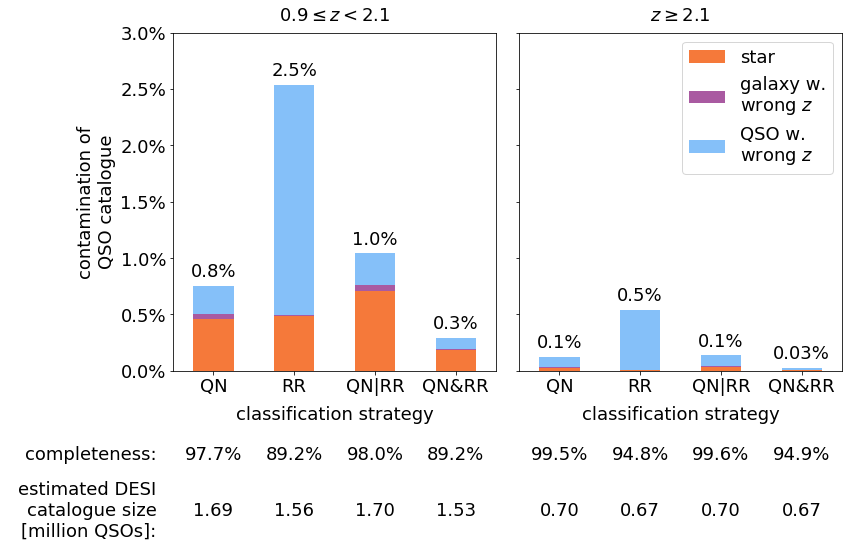

In [19]:
## Plot comparing QN, RR and simple combinations.
plot_strategies = ['QN coadd c_th=0.5','RR coadd','QN|RR','QN&RR']
names = {'QN coadd c_th=0.5': 'QN', 'RR coadd': 'RR', 'QN|RR': 'QN|RR','QN&RR': 'QN&RR'}
filename = '../plots/classifier_performance_constructing_a_catalogue.pdf'
ymax = 0.03

# Get the strategies.
strategies = {names[s]:stratdefs[s] for s in plot_strategies}

# Determine the filter.
data_used = ['QN coadd','RR coadd']
filt = utils.get_data_filter(data_table,data_used)

# Make the plot.
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=1,ymax=ymax,filter=filt)
plt.show()

INFO: 506202/601912 (84.1%) spectra used
RR
ncat 60375
nstar 309
ngalwrongz 5
nqsowrongz 1311
ncorrectwrongzbin 310
nwrong 1935
completeness 0.8906907273059806
7919 65612 0.12069438517344389

QN|RR
ncat 65530
nstar 471
ngalwrongz 36
nqsowrongz 181
ncorrectwrongzbin 505
nwrong 1193
completeness 0.9803542034993599
671 65612 0.010226787782722672

QN&RR
ncat 59116
nstar 115
ngalwrongz 1
nqsowrongz 63
ncorrectwrongzbin 409
nwrong 588
completeness 0.8920319453758458
6663 65612 0.10155154544900323

RR
ncat 177143
nstar 18
ngalwrongz 2
nqsowrongz 1168
ncorrectwrongzbin 173
nwrong 1361
completeness 0.943370506724484
10243 186334 0.05497118078289523

QN|RR
ncat 186043
nstar 60
ngalwrongz 20
nqsowrongz 179
ncorrectwrongzbin 286
nwrong 545
completeness 0.995513432867861
308 186334 0.0016529457855249175

QN&RR
ncat 176330
nstar 5
ngalwrongz 1
nqsowrongz 43
ncorrectwrongzbin 240
nwrong 289
completeness 0.9447604838623118
9939 186334 0.05333970182575375



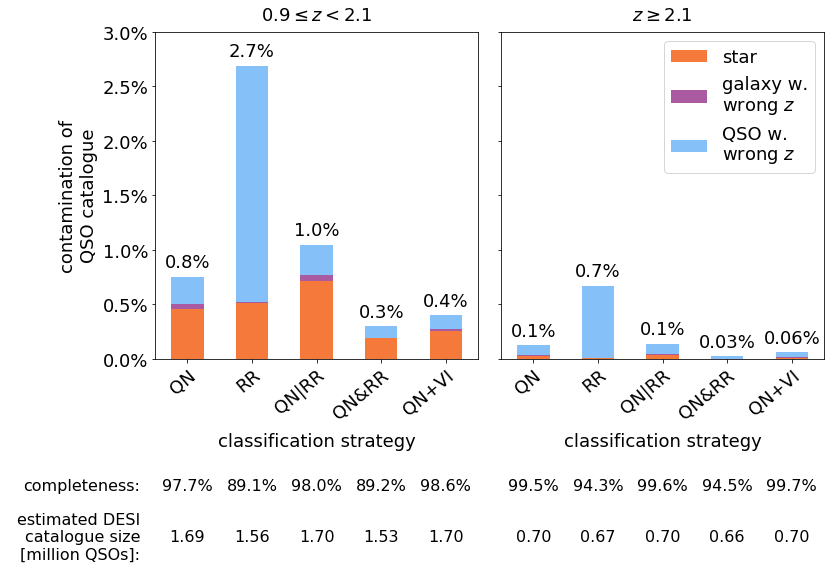

In [41]:
## Plot comparing QN, RR and simple combinations, using the andmask for redrock.
plot_strategies = ['QN coadd c_th=0.5','RR andmask coadd','QN|RR andmask coadd','QN&RR andmask coadd','QN+VI 1pc']
names = {'QN coadd c_th=0.5': 'QN', 
         'RR andmask coadd': 'RR', 
         'QN|RR andmask coadd': 'QN|RR',
         'QN&RR andmask coadd': 'QN&RR',
         'QN+VI 1pc': 'QN+VI'}
filename = '../plots/classifier_performance_constructing_a_catalogue_final.pdf'
ymax = 0.03

# Get the strategies.
strategies = {names[s]:stratdefs[s] for s in plot_strategies}

# Determine the filter.
data_used = ['QN coadd','RR andmask coadd']
filt = utils.get_data_filter(data_table,data_used)

# Make the plot.
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=(12,8.5),zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=True,nydec=1,ymax=ymax,filter=filt,extrarow=True,
                           rotation=40)

plt.show()

INFO: 506202/601912 (84.1%) spectra used
267508
485
10
1521
-179.08886693377923 780.6759942174601


(array([1.5000e+01, 1.8000e+01, 1.8000e+01, 2.5000e+01, 2.5000e+01,
        3.5000e+01, 3.2000e+01, 4.3000e+01, 4.9000e+01, 6.6000e+01,
        6.7000e+01, 5.7000e+01, 6.4000e+01, 6.2000e+01, 7.4000e+01,
        9.6000e+01, 1.1900e+02, 1.1400e+02, 1.2900e+02, 1.4500e+02,
        1.8200e+02, 2.2000e+02, 2.2700e+02, 2.7800e+02, 3.0500e+02,
        3.3900e+02, 4.2600e+02, 5.2300e+02, 5.9600e+02, 7.4000e+02,
        8.6400e+02, 1.0140e+03, 1.1730e+03, 1.4140e+03, 1.7120e+03,
        2.0800e+03, 2.2380e+03, 2.4980e+03, 2.9310e+03, 3.5940e+03,
        4.6100e+03, 5.9910e+03, 8.0320e+03, 1.0629e+04, 1.3691e+04,
        1.8252e+04, 2.6293e+04, 3.2841e+04, 3.2298e+04, 4.2908e+04,
        4.4851e+04, 2.1557e+04, 1.0619e+04, 6.3950e+03, 4.1870e+03,
        2.9400e+03, 2.0690e+03, 1.4870e+03, 1.1590e+03, 9.5300e+02,
        8.5100e+02, 6.2500e+02, 4.9600e+02, 3.7600e+02, 3.1000e+02,
        3.2200e+02, 2.7000e+02, 2.1900e+02, 1.9400e+02, 1.9300e+02,
        1.8500e+02, 1.7300e+02, 1.5300e+02, 1.75

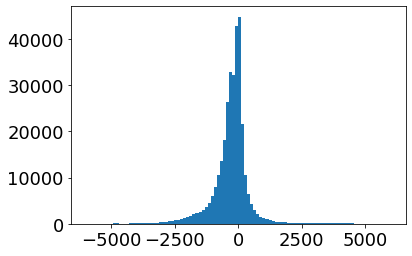

In [71]:
data_used = ['QN coadd','RR andmask coadd']
filt = utils.get_data_filter(data_table,data_used)

dv = (300000*(data_table['Z_RR andmask coadd']-data_table['Z_VI'])/(1+data_table['Z_VI']))
abs_dv = abs(dv)
isqso_rr = (data_table['CLASS_RR andmask coadd']=='QSO') & (data_table['ZWARN_RR andmask coadd']==0)

z_lo = 0.
z_hi = 20.1
w_zrr = (data_table['Z_RR andmask coadd']<z_hi) & (data_table['Z_RR andmask coadd']>=z_lo)
w_zvi = (data_table['Z_VI']<z_hi) & (data_table['Z_VI']>=z_lo)

w_cat = filt & w_zrr & \
        isqso_rr
w_true = filt & w_zvi & \
         (data_table['ISQSO_VI']==True)

w_right = w_cat & \
          ((data_table['ISQSO_VI']==True) | (data_table['CLASS_VI']=='GALAXY')) & \
          (abs_dv<6000)
w_wrong = w_cat & \
          ((data_table['CLASS_VI']=='STAR') | \
          (abs_dv>6000))

print(w_cat.sum())
print((w_cat & (data_table['CLASS_VI']=='STAR')).sum())
print((w_cat & (data_table['CLASS_VI']=='GALAXY') & (dv>dv_max)).sum())
print((w_cat & (data_table['CLASS_VI']=='QSO') & (dv>dv_max)).sum())

print(np.median(dv[w_right]),np.std(dv[w_right]))
plt.hist(dv[w_right],bins=100)

INFO: 503892/601912 (83.7%) spectra used


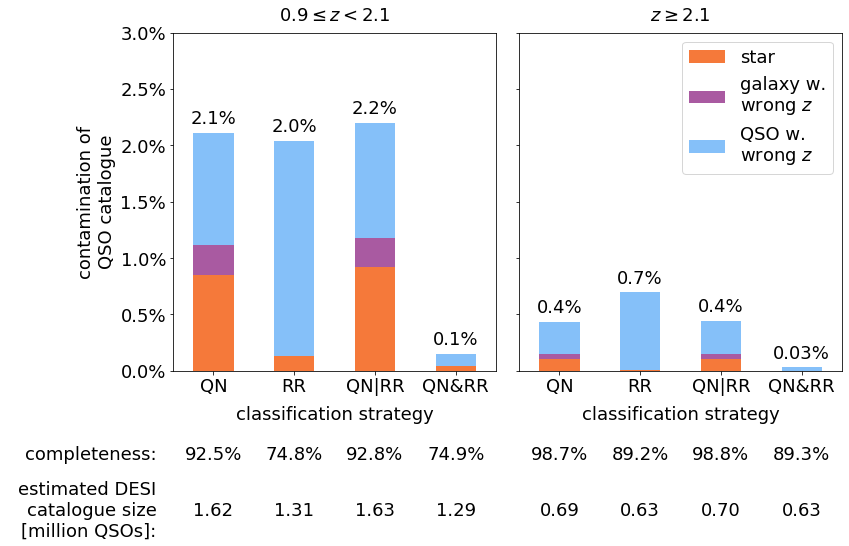

In [20]:
## Plot comparing QN, RR and simple combinations using random exposures.
plot_strategies = ['QN randexp','RRngp andmask randexp','QN|RRngp andmask randexp','QN&RRngp andmask randexp']
names = {'QN randexp': 'QN', 'RRngp andmask randexp': 'RR', 'QN|RRngp andmask randexp': 'QN|RR','QN&RRngp andmask randexp': 'QN&RR'}
filename = '../plots/classifier_performance_constructing_a_catalogue_randexp.pdf'
ymax = 0.03

# Get the strategies.
strategies = {names[s]:stratdefs[s] for s in plot_strategies}

# Determine the filter.
data_used = ['QN randexp','RRngp andmask randexp']
filt = utils.get_data_filter(data_table,data_used)

# Make the plot.
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=1,ymax=ymax,filter=filt)
plt.show()

INFO: 503762/601912 (83.7%) spectra used


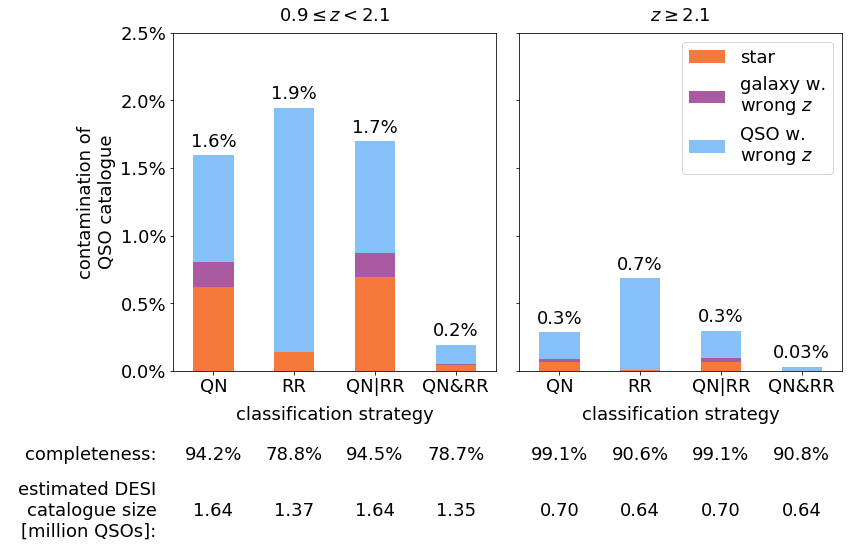

In [21]:
## Plot comparing QN, RR and simple combinations using best exposures.
plot_strategies = ['QN bestexp','RRngp andmask bestexp','QN|RRngp andmask bestexp','QN&RRngp andmask bestexp']
names = {'QN bestexp': 'QN', 'RRngp andmask bestexp': 'RR', 'QN|RRngp andmask bestexp': 'QN|RR','QN&RRngp andmask bestexp': 'QN&RR'}
filename = '../plots/classifier_performance_constructing_a_catalogue_bestexp.pdf'
ymax = 0.025

# Get the strategies.
strategies = {names[s]:stratdefs[s] for s in plot_strategies}

# Determine the filter.
data_used = ['QN bestexp','RRngp andmask bestexp']
filt = utils.get_data_filter(data_table,data_used)

# Make the plot.
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=1,ymax=ymax,filter=filt)
plt.show()

INFO: 506217/601912 (84.1%) spectra used


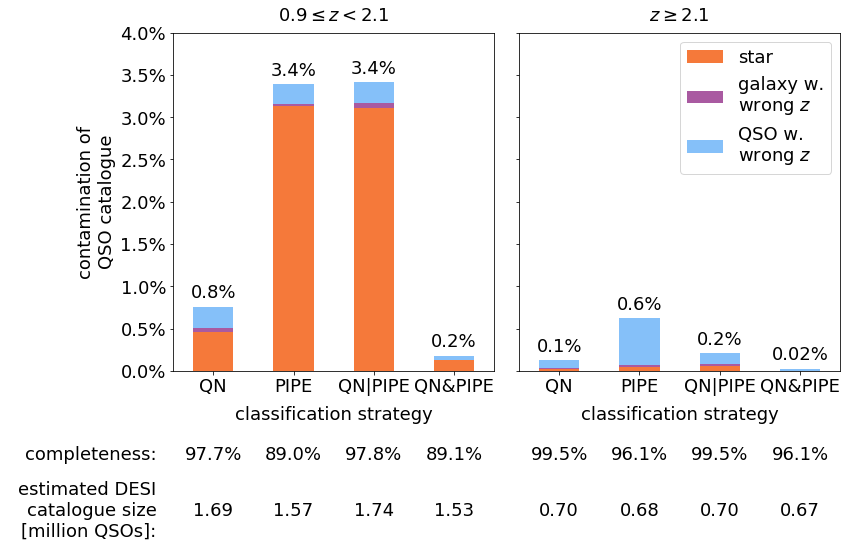

In [22]:
## As above but swapping redrock for DR12 pipeline
plot_strategies = ['QN coadd c_th=0.5','PIPE','QN|PIPE','QN&PIPE']
names = {'QN coadd c_th=0.5': 'QN', 'PIPE': 'PIPE', 'QN|PIPE': 'QN|PIPE','QN&PIPE': 'QN&PIPE'}
filename = '../plots/classifier_performance_constructing_a_catalogue_dr12pipe.pdf'
ymax = 0.04

# Get the strategies.
strategies = {names[s]:stratdefs[s] for s in plot_strategies}

# Determine the filter.
data_used = ['QN coadd','PIPE']
filt = utils.get_data_filter(data_table,data_used)

# Make the plot.
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=1,ymax=ymax,filter=filt)
plt.show()

INFO: 506217/601912 (84.1%) spectra used


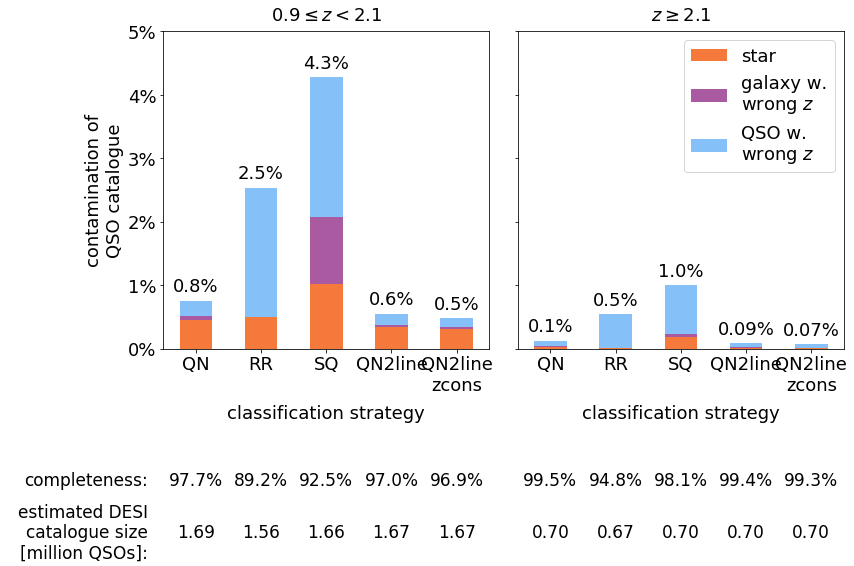

In [24]:
## Plot to compare different classifiers
plot_strategies = ['QN coadd c_th=0.5','RR coadd','SQ','QN2line coadd','QN2line coadd zcons']
names = {'QN coadd c_th=0.5': 'QN', 'RR coadd': 'RR', 'SQ': 'SQ','QN2line coadd': 'QN2line','QN2line coadd zcons':'QN2line\nzcons'}
filename = '../plots/classifier_performance_constructing_a_catalogue_altstrat.pdf'
ymax = 0.05

# Get the strategies.
strategies = {names[s]:stratdefs[s] for s in plot_strategies}

# Determine the filter.
data_used = ['QN coadd','RR coadd']#,'SQ']
filt = utils.get_data_filter(data_table,data_used)

# Make the plot.
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=0,ymax=ymax,filter=filt)
plt.show()

INFO: 464734/601912 (77.2%) spectra used


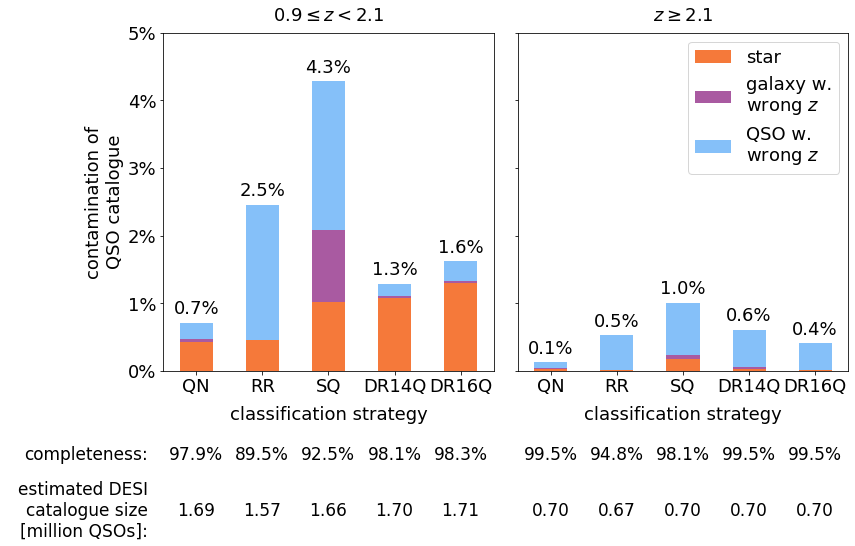

In [25]:
## Plot to compare different classifiers
plot_strategies = ['QN coadd c_th=0.5','RR coadd','SQ','DR14Q','DR16Q']
names = {'QN coadd c_th=0.5': 'QN', 'RR coadd': 'RR', 'SQ': 'SQ','DR14Q': 'DR14Q', 'DR16Q': 'DR16Q'}
filename = '../plots/classifier_performance_constructing_a_catalogue_altstrat_predeboss.pdf'
ymax = 0.05

# Get the strategies.
strategies = {names[s]:stratdefs[s] for s in plot_strategies}

# Determine the filter.
data_used = ['QN coadd','RR coadd','SQ','PIPE']
filt = utils.get_data_filter(data_table,data_used)

# Make the plot.
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=0,ymax=ymax,filter=filt)
plt.show()

INFO: 464734/601912 (77.2%) spectra used


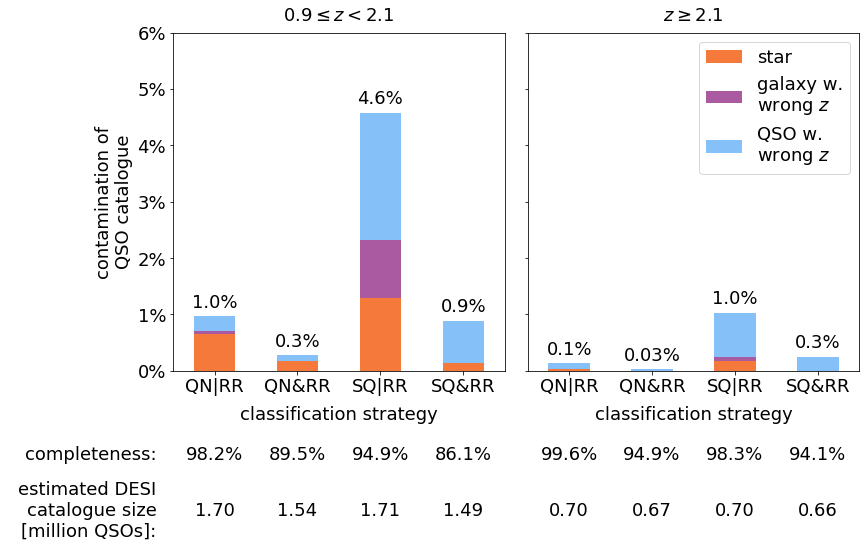

In [26]:
## Plot to compare different classifiers
plot_strategies = ['QN|RR','QN&RR','SQ|RR','SQ&RR']
names = {'QN|RR': 'QN|RR', 'QN&RR': 'QN&RR', 'SQ|RR': 'SQ|RR','SQ&RR': 'SQ&RR'}
filename = '../plots/classifier_performance_constructing_a_catalogue_altstratcomb.pdf'
ymax = 0.06

# Get the strategies.
strategies = {names[s]:stratdefs[s] for s in plot_strategies}

# Determine the filter.
data_used = ['QN coadd','RR coadd','SQ']
filt = utils.get_data_filter(data_table,data_used)

# Make the plot.
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=0,ymax=ymax,filter=filt)
plt.show()

INFO: 506202/601912 (84.1%) spectra used


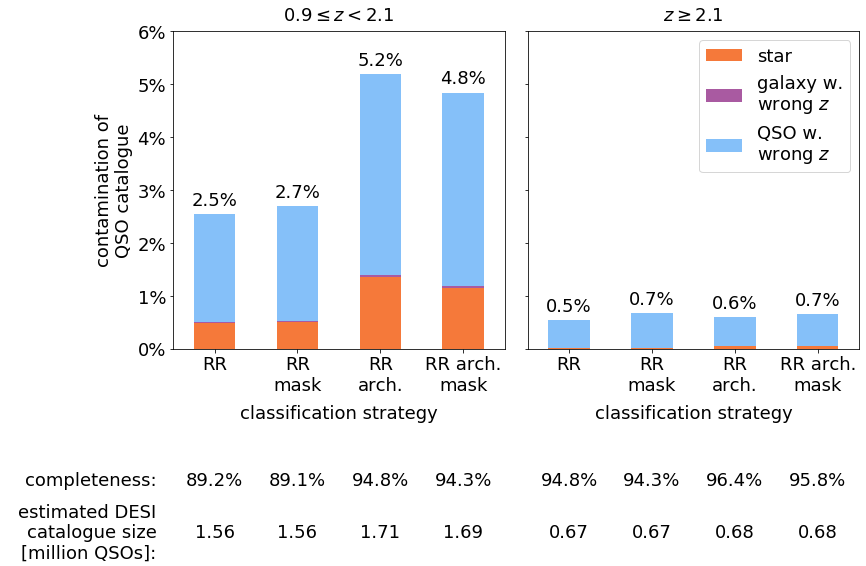

In [27]:
## Plot to show different redrock options.
plot_strategies = ['RR coadd','RR andmask coadd','RRarch','RRarch andmask']
names = {'RR coadd': 'RR', 
         'RR andmask coadd': 'RR\nmask', 
         'RRarch': 'RR\narch.',
         'RRarch andmask': 'RR arch.\nmask',}
filename = '../plots/classifier_performance_constructing_a_catalogue_rrtest.pdf'
ymax = 0.06

# Get the strategies.
strategies = {names[s]:stratdefs[s] for s in plot_strategies}

# Determine the filter.
data_used = ['RR coadd','RRarch','RR andmask coadd','QN coadd']
filt = utils.get_data_filter(data_table,data_used)

# Make the plot.
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=0,ymax=ymax,filter=filt)
plt.show()

INFO: 506202/601912 (84.1%) spectra used


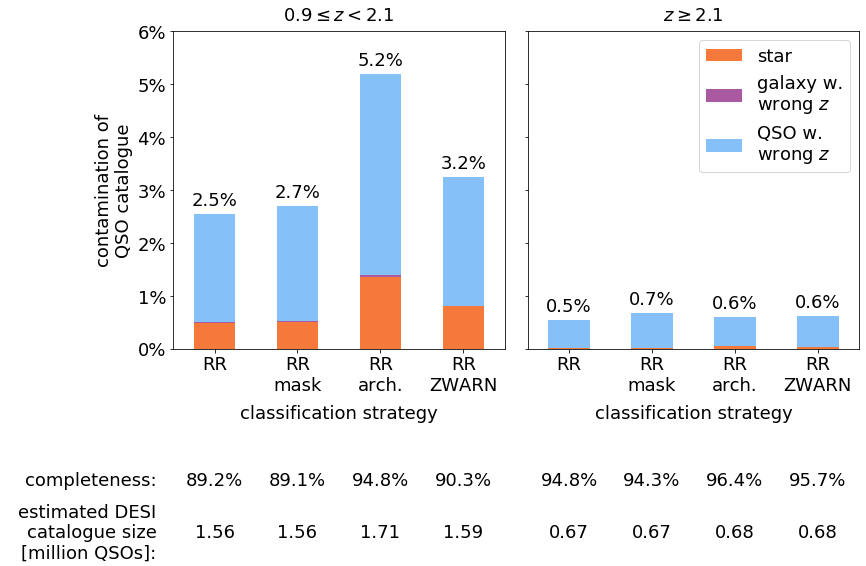

In [28]:
## Plot to show different redrock options.
plot_strategies = ['RR coadd','RR andmask coadd','RRarch','RRzwarn']
names = {'RR coadd': 'RR', 
         'RR andmask coadd': 'RR\nmask', 
         'RRarch': 'RR\narch.',
         'RRzwarn': 'RR\nZWARN',}
filename = '../plots/classifier_performance_constructing_a_catalogue_rrtest.pdf'
ymax = 0.06

# Get the strategies.
strategies = {names[s]:stratdefs[s] for s in plot_strategies}

# Determine the filter.
data_used = ['RR coadd','RRarch','RR andmask coadd','QN coadd']
filt = utils.get_data_filter(data_table,data_used)

# Make the plot.
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=0,ymax=ymax,filter=filt)
plt.show()

INFO: 506202/601912 (84.1%) spectra used


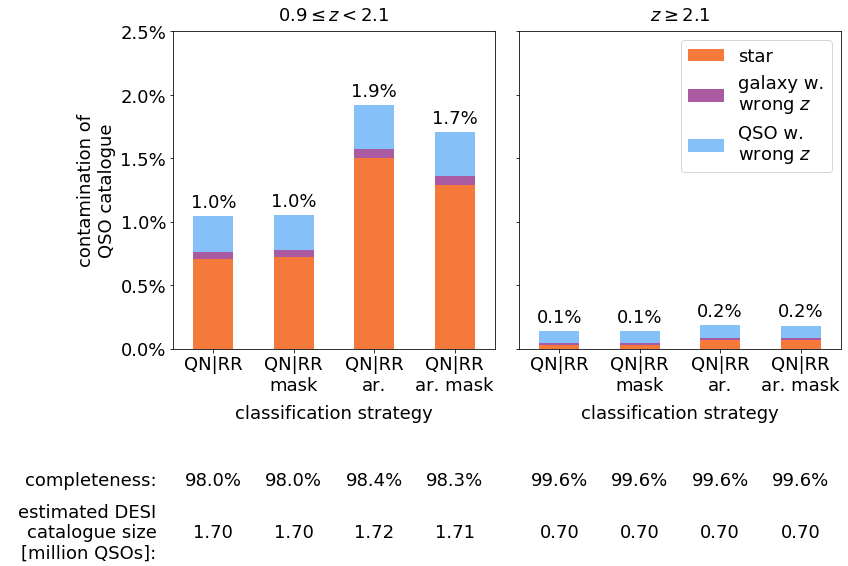

In [29]:
## Plot to show different redrock options.
plot_strategies = ['QN|RR','QN|RR andmask coadd','QN|RRarch','QN|RRarch andmask']
names = {'QN|RR': 'QN|RR', 
         'QN|RR andmask coadd': 'QN|RR\nmask', 
         'QN|RRarch': 'QN|RR\nar.',
         'QN|RRarch andmask': 'QN|RR\nar. mask',
        }
filename = '../plots/classifier_performance_constructing_a_catalogue_qnorrrtest.pdf'
ymax = 0.025

# Get the strategies.
strategies = {names[s]:stratdefs[s] for s in plot_strategies}

# Determine the filter.
data_used = ['RR coadd','RRarch','RR andmask coadd','QN coadd']
filt = utils.get_data_filter(data_table,data_used)

# Make the plot.
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=1,ymax=ymax,filter=filt)
plt.show()

INFO: 506202/601912 (84.1%) spectra used


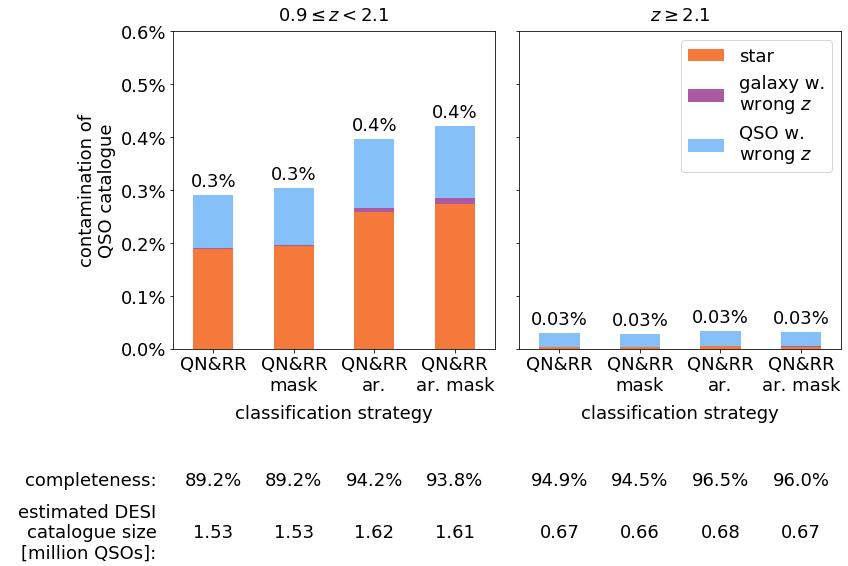

In [30]:
## Plot to show different redrock options.
plot_strategies = ['QN&RR','QN&RR andmask coadd','QN&RRarch','QN&RRarch andmask']
names = {'QN&RR': 'QN&RR', 
         'QN&RRarch': 'QN&RR\nar.',
         'QN&RR andmask coadd': 'QN&RR\nmask', 
         'QN&RRarch andmask': 'QN&RR\nar. mask',
        }
filename = '../plots/classifier_performance_constructing_a_catalogue_qnandrrtest.pdf'
ymax = 0.006

# Get the strategies.
strategies = {names[s]:stratdefs[s] for s in plot_strategies}

# Determine the filter.
data_used = ['RR coadd','RRarch','RR andmask coadd','QN coadd']
filt = utils.get_data_filter(data_table,data_used)

# Make the plot.
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=1,ymax=ymax,filter=filt)
plt.show()

INFO: 506217/601912 (84.1%) spectra used


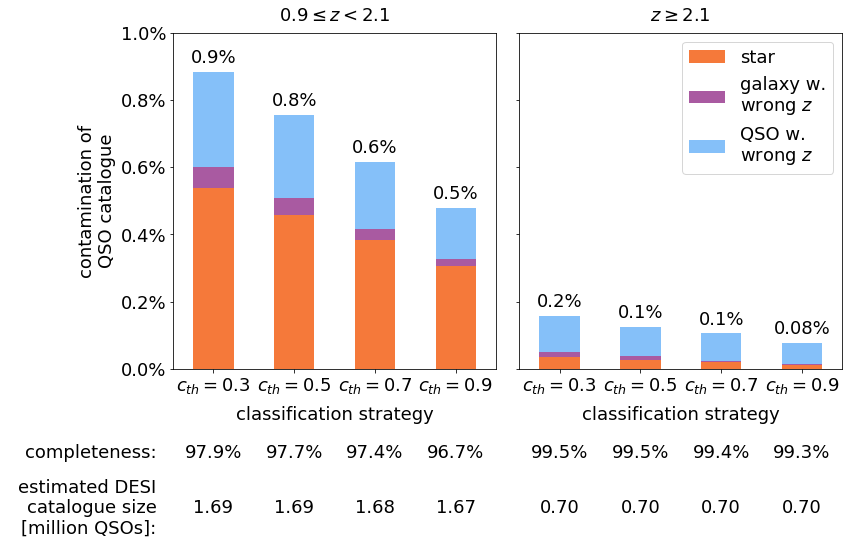

In [31]:
## Plot to show different QN c_th options.
plot_strategies = ['QN coadd c_th=0.3','QN coadd c_th=0.5','QN coadd c_th=0.7','QN coadd c_th=0.9']
names = {'QN coadd c_th=0.3': r'$c_{th}=0.3$', 
         'QN coadd c_th=0.5': r'$c_{th}=0.5$', 
         'QN coadd c_th=0.7': r'$c_{th}=0.7$', 
         'QN coadd c_th=0.9': r'$c_{th}=0.9$', 
        }
filename = '../plots/classifier_performance_constructing_a_catalogue_qncth.pdf'
ymax = 0.01

# Get the strategies.
strategies = {names[s]:stratdefs[s] for s in plot_strategies}

# Determine the filter.
data_used = ['QN coadd']
filt = utils.get_data_filter(data_table,data_used)

# Make the plot.
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=1,ymax=ymax,filter=filt)
plt.show()

INFO: 506217/601912 (84.1%) spectra used


/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:952: RuntimeWarning: invalid value encountered in true_divide
  pstar = np.array([strategies[s]['nstar'] for s in strategies.keys()])/ncat
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:953: RuntimeWarning: invalid value encountered in true_divide
  pgalwrongz = np.array([strategies[s]['ngalwrongz'] for s in strategies.keys()])/ncat
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:954: RuntimeWarning: invalid value encountered in true_divide
  pqsowrongz = np.array([strategies[s]['nqsowrongz'] for s in strategies.keys()])/ncat
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:955: RuntimeWarning: invalid value encountered in true_divide
  pcorrectwrongzbin = np.array([strategies[s]['ncorrectwrongzbin'] for s in strategies.keys()])/ncat
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/

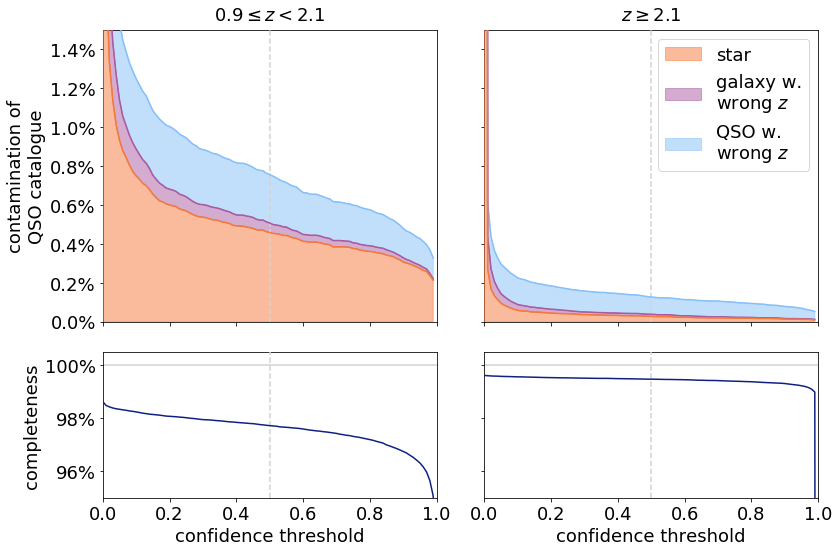

In [32]:
## Alternative plot to show different QN c_th options.
plot_strategies = ['QN coadd c_th={}'.format(c_th) for c_th in c_th_values]
filename = '../plots/classifier_performance_constructing_a_catalogue_qncth_alt.pdf'
ymax = 0.015

# Get the strategies.
strategies = {s:stratdefs[s] for s in plot_strategies}

# Determine the filter.
data_used = ['QN coadd']
filt = utils.get_data_filter(data_table,data_used)

# Make the plot.
fig, axs = plot.plot_catalogue_performance_vs_cth(data_table,strategies,filename=filename,
                           figsize=(12,8),zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=1,ymax=ymax,filter=filt,
                           ymin2=0.95,ymax2=1.005,c_th=c_th_values)
plt.show()

INFO: 506217/601912 (84.1%) spectra used


/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:952: RuntimeWarning: invalid value encountered in true_divide
  pstar = np.array([strategies[s]['nstar'] for s in strategies.keys()])/ncat
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:953: RuntimeWarning: invalid value encountered in true_divide
  pgalwrongz = np.array([strategies[s]['ngalwrongz'] for s in strategies.keys()])/ncat
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:954: RuntimeWarning: invalid value encountered in true_divide
  pqsowrongz = np.array([strategies[s]['nqsowrongz'] for s in strategies.keys()])/ncat
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:955: RuntimeWarning: invalid value encountered in true_divide
  pcorrectwrongzbin = np.array([strategies[s]['ncorrectwrongzbin'] for s in strategies.keys()])/ncat
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/

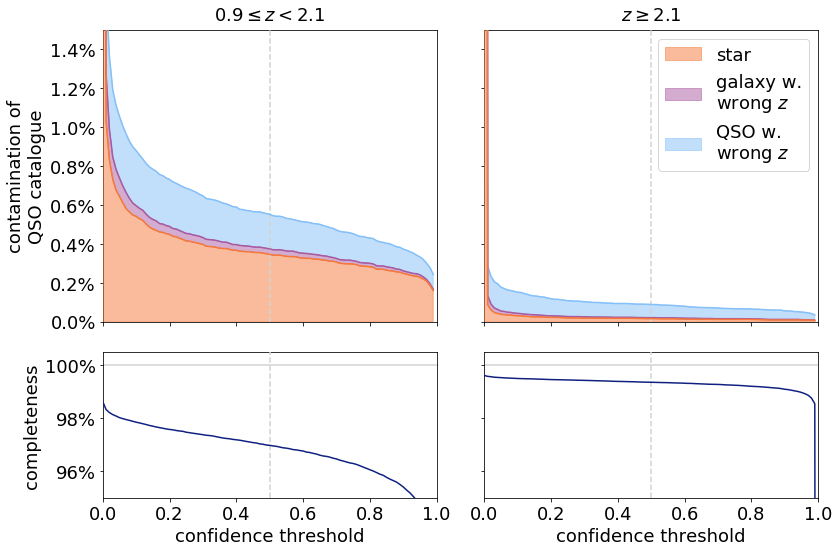

In [33]:
## Alternative plot to show different QN2line c_th options.
plot_strategies = ['QN2line coadd c_th={}'.format(c_th) for c_th in c_th_values]
filename = '../plots/classifier_performance_constructing_a_catalogue_qncth2line_alt.pdf'
ymax = 0.015

# Get the strategies.
strategies = {s:stratdefs[s] for s in plot_strategies}

# Determine the filter.
data_used = ['QN coadd']
filt = utils.get_data_filter(data_table,data_used)

# Make the plot.
fig, axs = plot.plot_catalogue_performance_vs_cth(data_table,strategies,filename=filename,
                           figsize=(12,8),zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=1,ymax=ymax,filter=filt,
                           ymin2=0.95,ymax2=1.005,c_th=c_th_values)
plt.show()

INFO: 506217/601912 (84.1%) spectra used


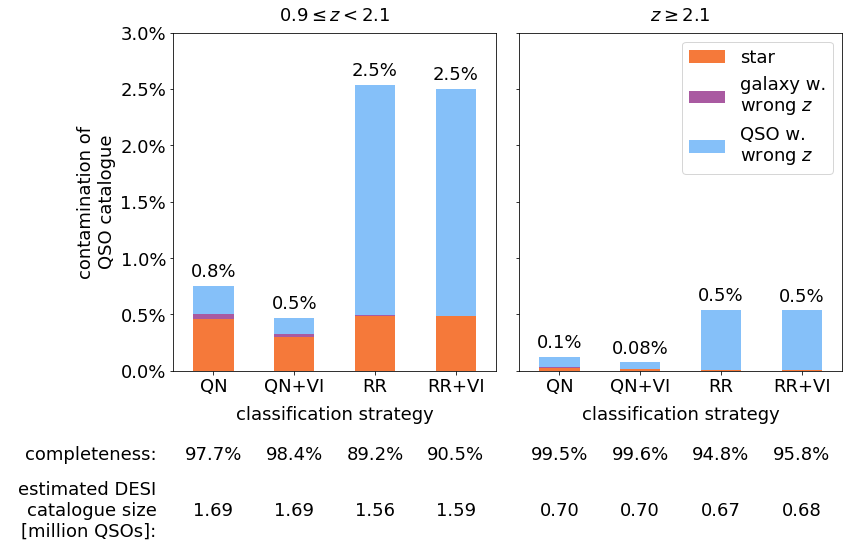

In [34]:
## Plot to test introducing VI on ``difficult'' spectra.
plot_strategies = ['QN coadd c_th=0.5','QN+VI','RR coadd','RR+VI']#,'RR+VI alt.']
names = {'QN coadd c_th=0.5': 'QN', 'QN+VI': 'QN+VI', 'RR coadd': 'RR', 'RR+VI': 'RR+VI',}#'RR+VI alt.':'RR+VI alt.'}
filename = '../plots/classifier_performance_constructing_a_catalogue_plusvi.pdf'
ymax = 0.03

# Get the strategies.
strategies = {names[s]:stratdefs[s] for s in plot_strategies}

# Determine the filter.
data_used = ['QN coadd','RR coadd']
filt = utils.get_data_filter(data_table,data_used)

# Make the plot.
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=1,ymax=ymax,filter=filt)
plt.show()

In [60]:
## Plot to further test introducing VI on ``difficult'' spectra.
plot_strategies = ['QN+VI','RR+VI','QN&RR+VI','QN&RR+VI adv.','test']
names = {'QN+VI': 'QN+VI', 'RR+VI': 'RR+VI', 'QN&RR+VI': 'QN&RR+VI', 'QN&RR+VI adv.': 'QN&RR+VI adv.', 'test': 'test'}
filename = '../plots/classifier_performance_constructing_a_catalogue_complex.pdf'
ymax = 0.05

# Get the strategies.
strategies = {names[s]:stratdefs[s] for s in plot_strategies}

# Determine the filter.
data_used = ['QN coadd','RR coadd']
filt = utils.get_data_filter(data_table,data_used)

# Make the plot.
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=0,ymax=ymax,filter=filt)
plt.show()

KeyError: 'test'

INFO: 506217/601912 (84.1%) spectra used


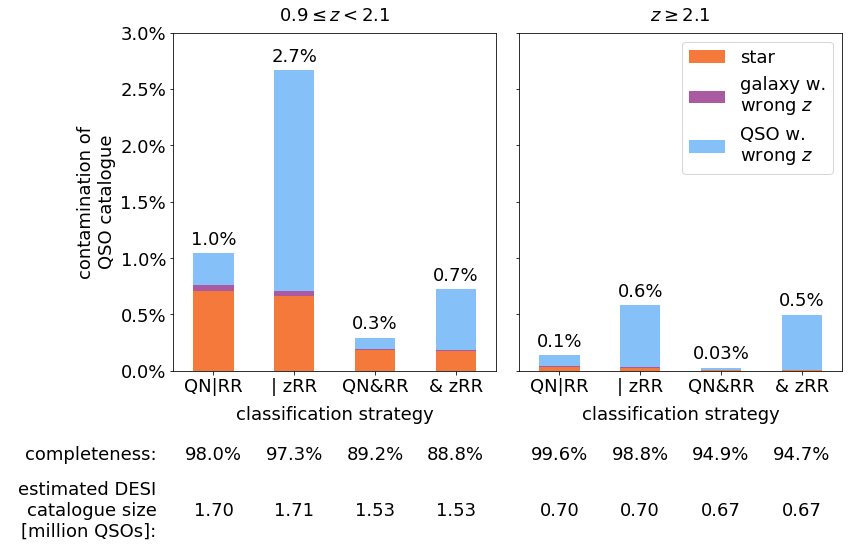

In [35]:
## Compare choice of redshift in simple combination strategies.
plot_strategies = ['QN|RR','| zRR','QN&RR','& zRR']
names = {'QN|RR': 'QN|RR', '| zRR': '| zRR', 'QN&RR': 'QN&RR', '& zRR': '& zRR'}
filename = '../plots/classifier_performance_constructing_a_catalogue_zrr.pdf'
ymax = 0.03

# Get the strategies.
strategies = {names[s]:stratdefs[s] for s in plot_strategies}

# Determine the filter.
data_used = ['QN coadd','RR coadd']
filt = utils.get_data_filter(data_table,data_used)

# Make the plot.
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=1,ymax=ymax,filter=filt)
plt.show()

INFO: 506217/601912 (84.1%) spectra used


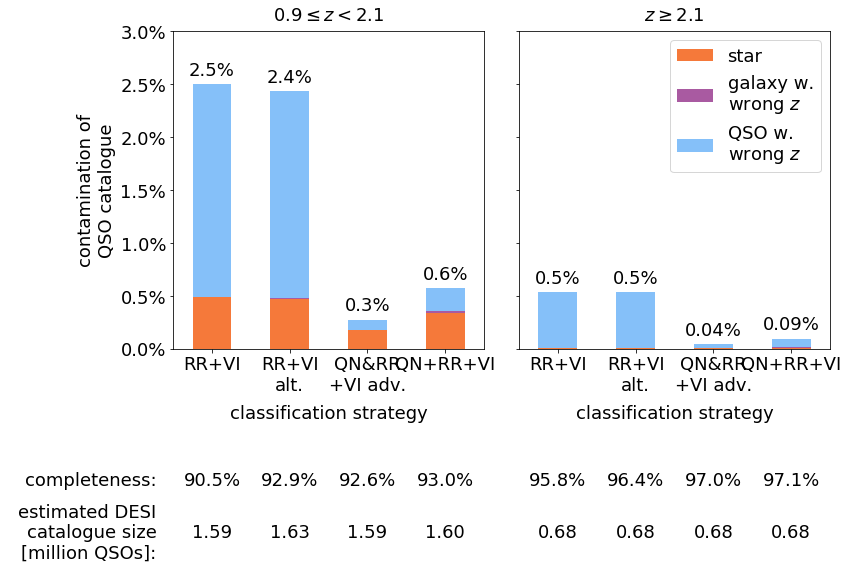

In [36]:
## Plot to further test introducing VI on ``difficult'' spectra.
plot_strategies = ['RR+VI','RR+VI alt.','QN&RR+VI adv.','QN+RR+VI']
names = {'RR+VI': 'RR+VI', 'RR+VI alt.': 'RR+VI\nalt.', 'QN&RR+VI adv.': 'QN&RR+VI\nadv.', 'QN+RR+VI': 'QN+RR\n+VI'}
filename = '../plots/classifier_performance_constructing_a_catalogue_rrplusviopt.pdf'
ymax = 0.03

# Get the strategies.
strategies = {names[s]:stratdefs[s] for s in plot_strategies}

# Determine the filter.
data_used = ['QN coadd','RR coadd']
filt = utils.get_data_filter(data_table,data_used)

# Make the plot.
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=1,ymax=ymax,filter=filt)
plt.show()